In [2]:
import EddyDetectionV2 as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

# Set default font size to match LaTeX document
plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 12 # Figure title size
})

# Import data

In [3]:
JMFZ_region = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/FWT/JMFZFWT.nc')['shelfExtended'].assign_attrs(
    units="mSv", description="Freshwater transport"
).rename('FWT_70_74N')
eddyRegion = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Eddies_fullYear.nc')['EddyDetection'].sel(Y=slice(70,74),X=slice(-22,0))
eddyRegion.attrs = {}
eddyRegion = eddyRegion.assign_attrs(
    unit="Eddy type (1 == anti-cyclonic, 2 == cyclonic)", description="Outermost closed SSH defined eddy region"
)

eddyAreaID = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/EddyResults/Tracking/EddyAreaID.nc')['EddyID'].sel(Y=slice(70,74),X=slice(-22,0))
eddyAreaID.attrs = {}
eddyAreaID = eddyAreaID.assign_attrs(
    unit="Eddy ID", description="Eddy region with unique ID"
)

depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(70,74),X=slice(-22,0))
depth_no_nan = depth

depth = depth.where(depth > 0, np.nan)

FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(70,74)).sel(X=slice(-22,0))
FWC = FWC.resample(time='D').mean(dim='time').rename('FWC')

# Time of FWT sink

Text(<xarray.DataArray 'time' ()>
array('2018-08-12T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-08-12
    Y        int64 ...
    X        int64 ...
Attributes:
    long_name:  model_time, 12, '(b)')

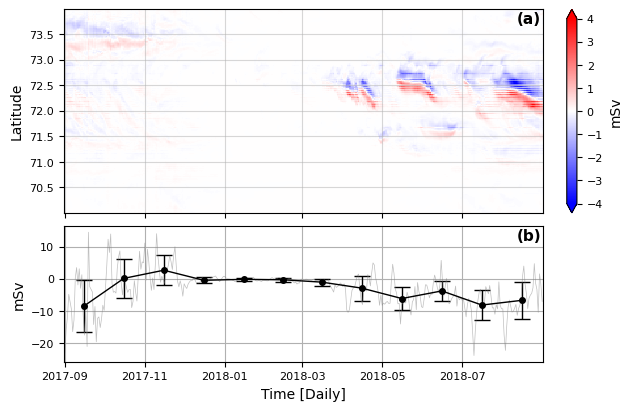

In [4]:
def err_resample(dataset_d):
    resampled_data = dataset_d.resample(time='ME').std()
    new_time = []
    for date in resampled_data['time'].values:
        date = pd.Timestamp(date)
        start_of_month = date.replace(day=1)
        end_of_month = (start_of_month + pd.DateOffset(months=1)) - pd.Timedelta(days=1)
        midpoint_of_month = start_of_month + (end_of_month - start_of_month) / 2
        new_time.append(midpoint_of_month)
    resampled_data['time'] = pd.to_datetime(new_time)
    return resampled_data


fig, ax = plt.subplot_mosaic([['u'],['l']],
    gridspec_kw={'height_ratios': [0.6,0.4]},
    figsize=(6.2217,4),
    sharex=True,
    layout='constrained'
)

cmap = plt.get_cmap('bwr')

mesh = ax['u'].pcolormesh(JMFZ_region.time, JMFZ_region.YC, JMFZ_region.transpose(),cmap=cmap,vmin=-4,vmax=4)
cbar = fig.colorbar(mesh, extend='both')
cbar.set_label('mSv')

ax['u'].grid(alpha=0.5)
ax['u'].set_ylabel('Latitude')
ax['u'].annotate('(a)',xy=[JMFZ_region.time[-20],73.7],fontweight='bold')

sum_time = JMFZ_region.sum(dim='mooring')
std_month = err_resample(sum_time)
ax['l'].errorbar(std_month.time.values,sum_time.resample(time='ME').mean(),std_month,fmt='o-', color='black',markersize=4,linewidth=1, capsize=6)
ax['l'].plot(sum_time.time,sum_time,color='grey',alpha=0.5,linewidth=0.5)
ax['l'].grid()

ax['l'].set_xlabel('Time [Daily]')
ax['l'].set_ylabel('mSv')
ax['l'].annotate('(b)',xy=[JMFZ_region.time[-20],12],fontweight='bold')


(17610.0, 17774.0)

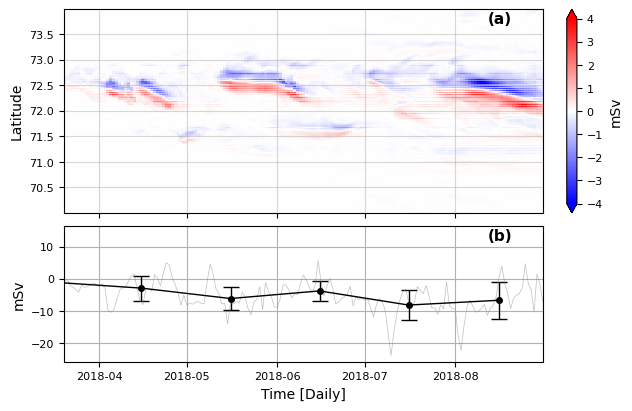

In [5]:
fig, ax = plt.subplot_mosaic([['u'],['l']],
    gridspec_kw={'height_ratios': [0.6,0.4]},
    figsize=(6.2217,4),
    sharex=True,
    layout='constrained'
)

cmap = plt.get_cmap('bwr')

mesh = ax['u'].pcolormesh(JMFZ_region.time, JMFZ_region.YC, JMFZ_region.transpose(),cmap=cmap,vmin=-4,vmax=4)
cbar = fig.colorbar(mesh, extend='both')
cbar.set_label('mSv')

ax['u'].grid(alpha=0.5)
ax['u'].set_ylabel('Latitude')
ax['u'].annotate('(a)',xy=[JMFZ_region.time[-20],73.7],fontweight='bold')

sum_time = JMFZ_region.sum(dim='mooring')
std_month = err_resample(sum_time)
ax['l'].errorbar(std_month.time.values,sum_time.resample(time='ME').mean(),std_month,fmt='o-', color='black',markersize=4,linewidth=1, capsize=6)
ax['l'].plot(sum_time.time,sum_time,color='grey',alpha=0.5,linewidth=0.5)
ax['l'].grid()

ax['l'].set_xlabel('Time [Daily]')
ax['l'].set_ylabel('mSv')
ax['l'].annotate('(b)',xy=[JMFZ_region.time[-20],12],fontweight='bold')
ax['l'].set_xlim(sum_time.time[200],sum_time.time[-1])

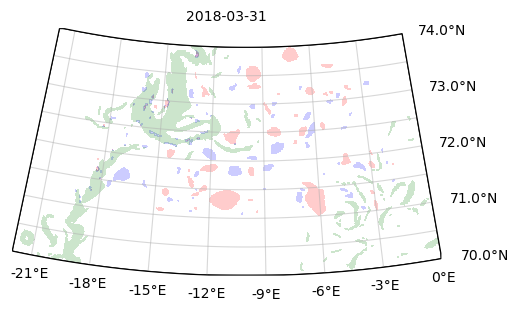

In [6]:
fig, ax = plt.subplots(
        figsize=(6.2217,3), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout = 'constrained'
)
# Set the extent to focus on the desired geographical area
extent = [-22+10, 0+10, 70, 74]

ax.contourf(eddyRegion.X.sel(X=slice(-22,0)),eddyRegion.Y.sel(Y=slice(70,74)),eddyRegion[211].sel(X=slice(-22,0),Y=slice(70,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2,transform=ccrs.PlateCarree())
# Title
ax.set_title(str(eddyRegion.time[211].values)[0:10])

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
np.column_stack([bottom_lons, bottom_lats]),
np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines without labels
gl = ax.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-9, extent[1]-10 + 1, 3)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 0.5, 1)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
        ax.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
        ax.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                fontsize=10, ha='left', va='center')

In [7]:
time_ = np.arange(200,365)
for time in time_:
    fig, ax = plt.subplots(
        figsize=(6.2217,3), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout = 'constrained'
    )

    # Set the extent to focus on the desired geographical area
    extent = [-22+10, 0+10, 70, 74]

    lon = depth['XC']
    lat = depth['YC']

    land = depth_no_nan.where(depth_no_nan==0)

    mesh = ax.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5, transform=ccrs.PlateCarree(),zorder=0)
    cbar = fig.colorbar(mesh, shrink=0.7,pad=0.01,extend='max')
    cbar.set_label('FWC [m]')

    ax.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0, transform=ccrs.PlateCarree())

    # Add land contour
    ax.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0, transform=ccrs.PlateCarree())
    ax.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3, transform=ccrs.PlateCarree())

    # Eastern boundary
    ax.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary',transform=ccrs.PlateCarree())

    # Ridge
    ax.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='c',label='Ridge',transform=ccrs.PlateCarree())

    # Eddies
    ax.contourf(eddyRegion.X.sel(X=slice(-22,0)),eddyRegion.Y.sel(Y=slice(70,74)),eddyRegion[time].sel(X=slice(-22,0),Y=slice(70,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2,transform=ccrs.PlateCarree())


    # Title
    ax.set_title(str(eddyRegion.time[time].values)[0:10])

    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
    ax.add_patch(patch)

    # Set the boundary using the transformed path
    ax.set_boundary(patch.get_path(), transform=ax.transData)

    # Add gridlines without labels
    gl = ax.gridlines(draw_labels=False,alpha=0.5)

    # Manually add the labels for the bottom and right sides
    xticks = np.arange(extent[0]-9, extent[1]-10 + 1, 3)  # Adjust the range and step as needed
    yticks = np.arange(extent[2], extent[3] + 0.5, 1)  # Adjust the range and step as needed

    # Add bottom labels
    for xtick in xticks:
        ax.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='top')

    # Add right labels
    for ytick in yticks:
        ax.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                fontsize=10, ha='left', va='center')
    
    ax.legend(loc='upper right')


    # Save the figure
    fig.savefig(f'/nird/home/ekv036/MSc/Fig/CaseStudy/{str(eddyRegion.time[time].values)[0:10]}',dpi=300, facecolor='w', edgecolor='w',
            orientation='landscape', format=None,
            transparent=False, bbox_inches=None,pad_inches=0.25)
    plt.close()

In [8]:
from PIL import Image
import os

# Define the folder containing the PNG files and the output GIF file
input_folder = '/nird/home/ekv036/MSc/Fig/CaseStudy'
output_gif = '/nird/home/ekv036/MSc/Animations/JMFZ_region_200_365.gif'

# Get a list of all PNG files in the folder
png_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

# Sort the files if necessary (e.g., if they need to be in a specific order)
png_files.sort()

# Open the images and store them in a list
images = [Image.open(os.path.join(input_folder, file)) for file in png_files]

# Save the images as a GIF
images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

print(f"GIF saved as {output_gif}")

GIF saved as /nird/home/ekv036/MSc/Animations/JMFZ_region_200_365.gif
